In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## *Reading The Dataset*

In [ ]:
df = pd.read_csv('/content/azure.csv')
df.head()

,timestamp,min cpu,max cpu,avg cpu
0,2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
1,2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2,2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
3,2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
4,2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06


In [ ]:
df.describe()

,min cpu,max cpu,avg cpu
count,8.640000e+03,8.640000e+03,8.640000e+03
mean,7.075603e+05,2.205312e+06,1.215661e+06
std,5.372051e+04,1.723607e+05,1.096154e+05
min,5.862266e+05,1.823027e+06,9.786379e+05
25%,6.675541e+05,2.072256e+06,1.125854e+06
50%,7.050560e+05,2.196693e+06,1.210631e+06
75%,7.411543e+05,2.330497e+06,1.298056e+06
max,1.151024e+06,3.529283e+06,1.821756e+06


In [ ]:
df.corr()

,min cpu,max cpu,avg cpu
min cpu,1.000000,0.885243,0.958884
max cpu,0.885243,1.000000,0.967936
avg cpu,0.958884,0.967936,1.000000


## Pre-Processing

### *Setting date and time as the index of the dataframe and processing it since it is a string*

In [ ]:
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()

,min cpu,max cpu,avg cpu
timestamp,,,
2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06


### *Checking for Null/Nan Values*

In [ ]:
df.isnull()

,min cpu,max cpu,avg cpu
timestamp,,,
2017-01-01 00:00:00,False,False,False
2017-01-01 00:05:00,False,False,False
2017-01-01 00:10:00,False,False,False
2017-01-01 00:15:00,False,False,False
2017-01-01 00:20:00,False,False,False
...,...,...,...
2017-01-30 23:35:00,False,False,False
2017-01-30 23:40:00,False,False,False
2017-01-30 23:45:00,False,False,False


In [ ]:
df.notnull()

,min cpu,max cpu,avg cpu
timestamp,,,
2017-01-01 00:00:00,True,True,True
2017-01-01 00:05:00,True,True,True
2017-01-01 00:10:00,True,True,True
2017-01-01 00:15:00,True,True,True
2017-01-01 00:20:00,True,True,True
...,...,...,...
2017-01-30 23:35:00,True,True,True
2017-01-30 23:40:00,True,True,True
2017-01-30 23:45:00,True,True,True


In [ ]:
df.isna().sum()

min cpu    0
max cpu    0
avg cpu    0
dtype: int64

## *Visualization of the Data*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45c263d8d0>,
      dtype=object)

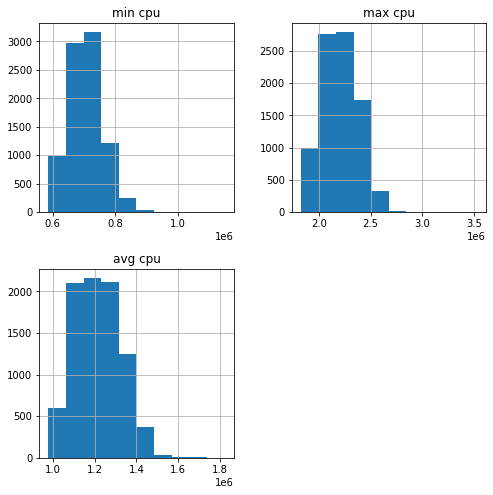

In [ ]:
df.hist(figsize=(8, 8))

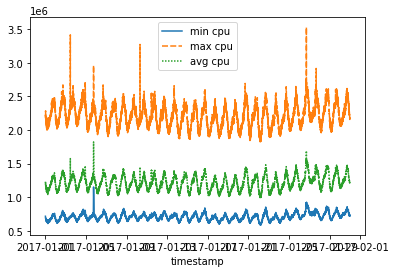

In [ ]:
sns.lineplot(data=df)

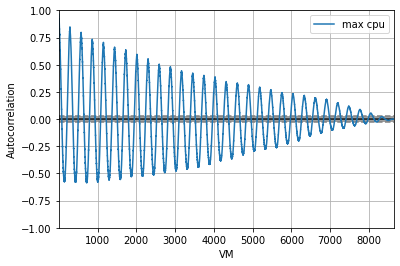

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['max cpu'],label='max cpu')
plt.xlabel('VM')
plt.show()

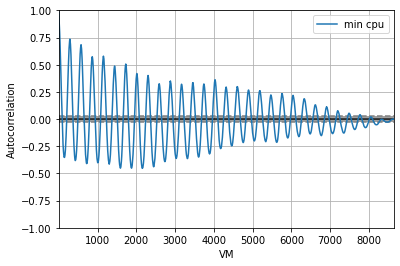

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['min cpu'],label='min cpu')
plt.xlabel('VM')
plt.show()

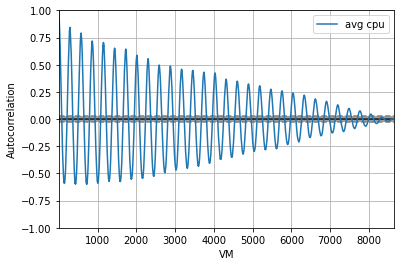

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['avg cpu'],label='avg cpu')
plt.xlabel('VM')
plt.show()

### *Spliting the Data into Test and Train*

In [ ]:
train_length = round(len(df)*0.8) #finding the length of the df and multiplying it by 0.8
test_length = len(df) - train_length #test length can be found out by by subtracting the length of the df with the train data length
train = df.iloc[0:train_length] #Train dataset construction
test = df[train_length : ] #Test dataset construction

### *Scaling the Values On the Dataset*

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)

### *Creating function to feed data to a model*

In [ ]:
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset)- n_lags -1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

### *Making X_train, X_test, Y_train, Y_test*

In [ ]:
TIME_STEPS = 500 # Time steps are basically how many time intervals we want per sample
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

### Making a LSTM model and training and testing on it

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.LSTM(512,return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 500, 512)          1056768   
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 3,157,507
Trainable params: 3,157,507
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [ ]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [38]:
callbacks = [es , lr_red]
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_split=0.25,
                    batch_size=256,
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)

Epoch 1/10
19/19 [==============================] - 1362s 71s/step - loss: 0.0796 - val_loss: 0.0448 - lr: 0.0010
Epoch 2/10
19/19 [==============================] - 1294s 68s/step - loss: 0.0339 - val_loss: 0.0314 - lr: 0.0010
Epoch 3/10
19/19 [==============================] - 1335s 71s/step - loss: 0.0258 - val_loss: 0.0219 - lr: 0.0010
Epoch 4/10
19/19 [==============================] - 1322s 70s/step - loss: 0.0235 - val_loss: 0.0216 - lr: 0.0010
Epoch 5/10
19/19 [==============================] - 1379s 73s/step - loss: 0.0223 - val_loss: 0.0215 - lr: 0.0010
Epoch 6/10
19/19 [==============================] - 1365s 72s/step - loss: 0.0218 - val_loss: 0.0205 - lr: 0.0010
Epoch 7/10
19/19 [==============================] - 1392s 73s/step - loss: 0.0213 - val_loss: 0.0200 - lr: 0.0010
Epoch 8/10
19/19 [==============================] - 1353s 71s/step - loss: 0.0206 - val_loss: 0.0197 - lr: 0.0010
Epoch 9/10
19/19 [==============================] - 1332s 70s/step - loss: 0.0203 - val_

### Saving the Model

In [39]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://30e6b7eb-125a-47d3-b280-6f3b914e48a4/assets


INFO:tensorflow:Assets written to: ram://30e6b7eb-125a-47d3-b280-6f3b914e48a4/assets


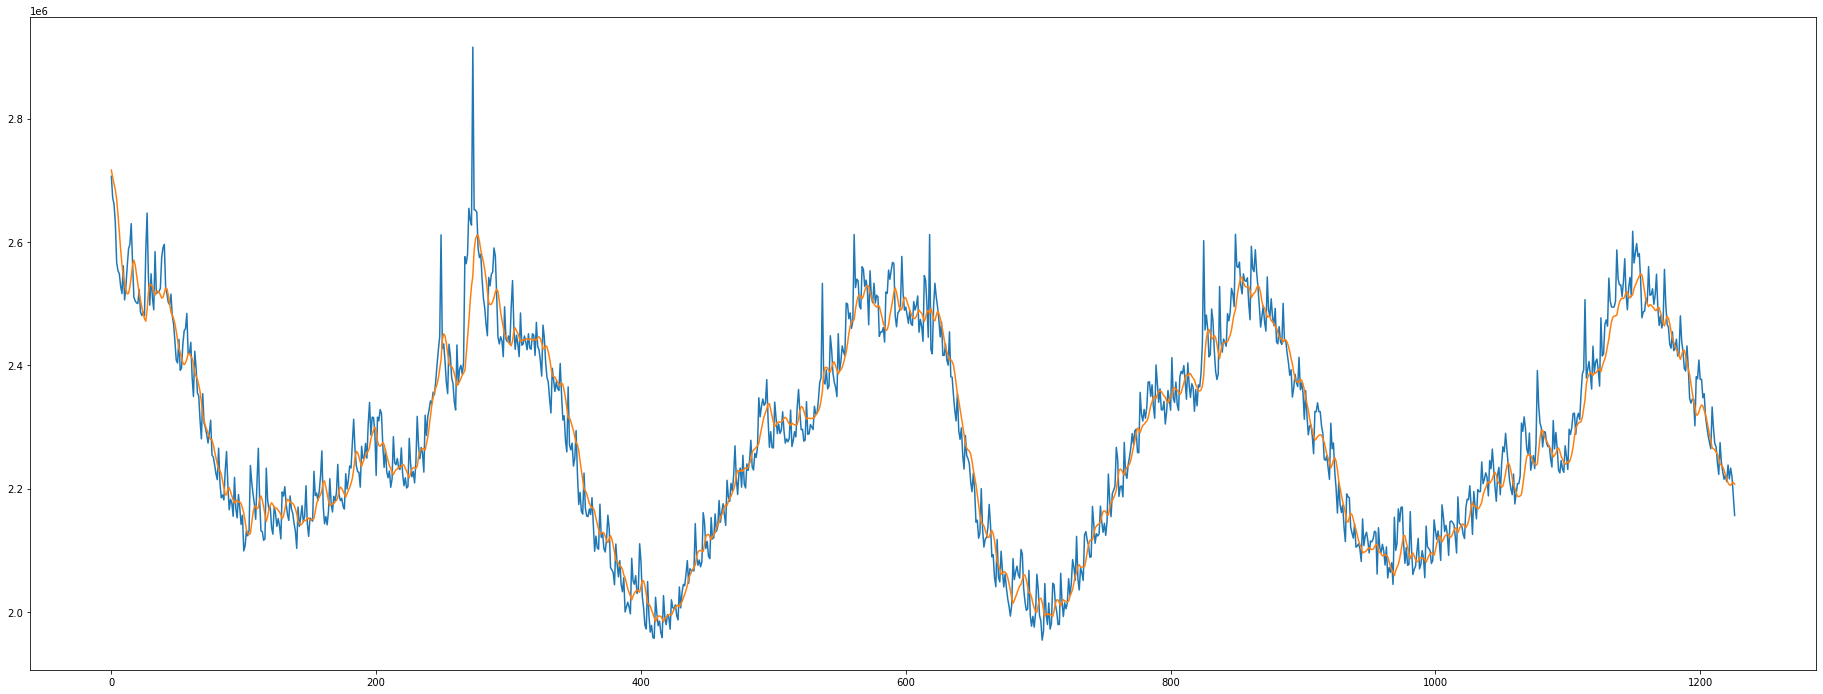

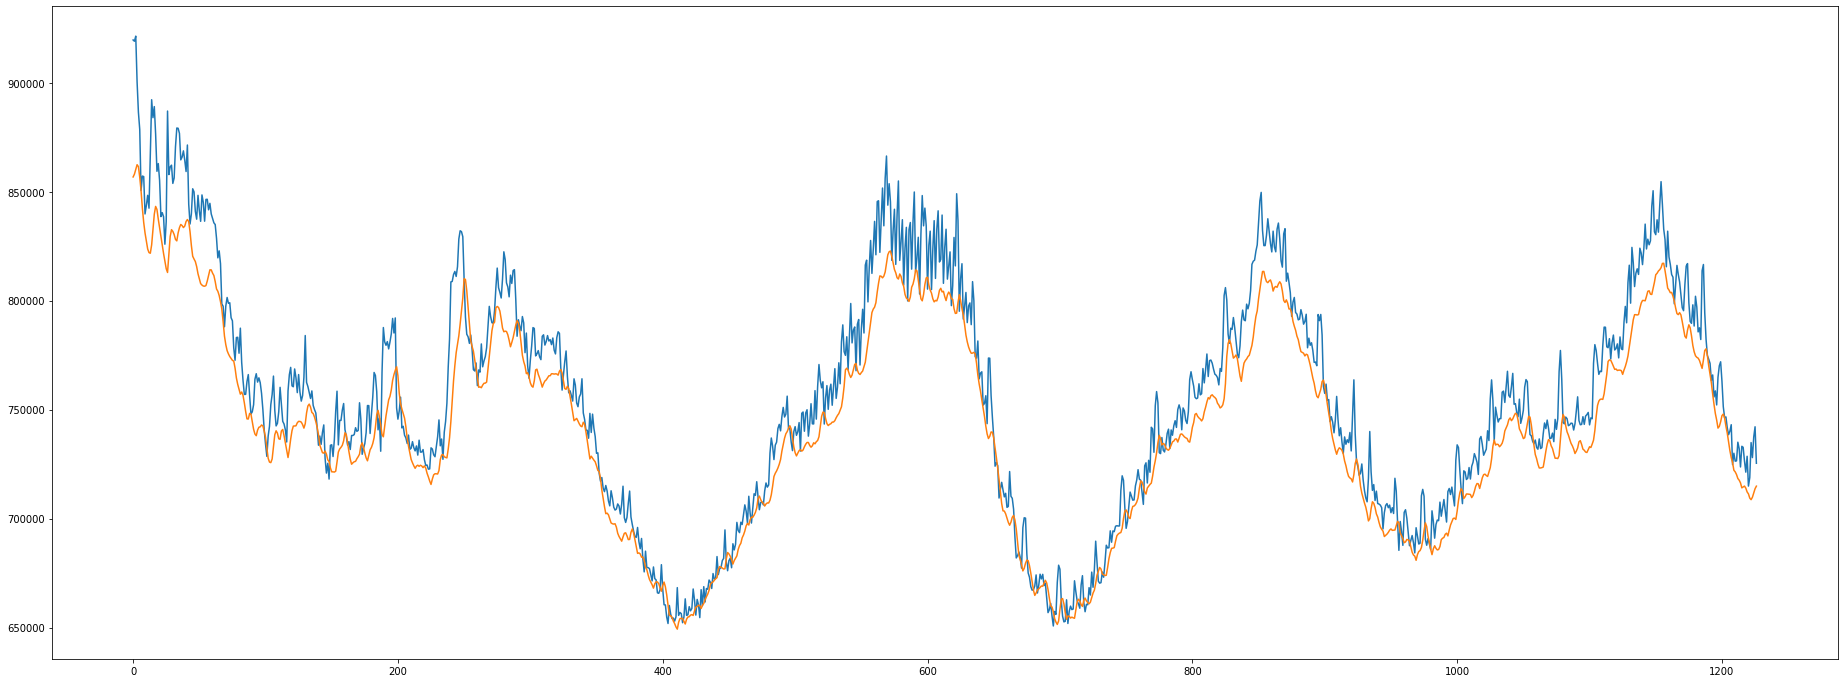

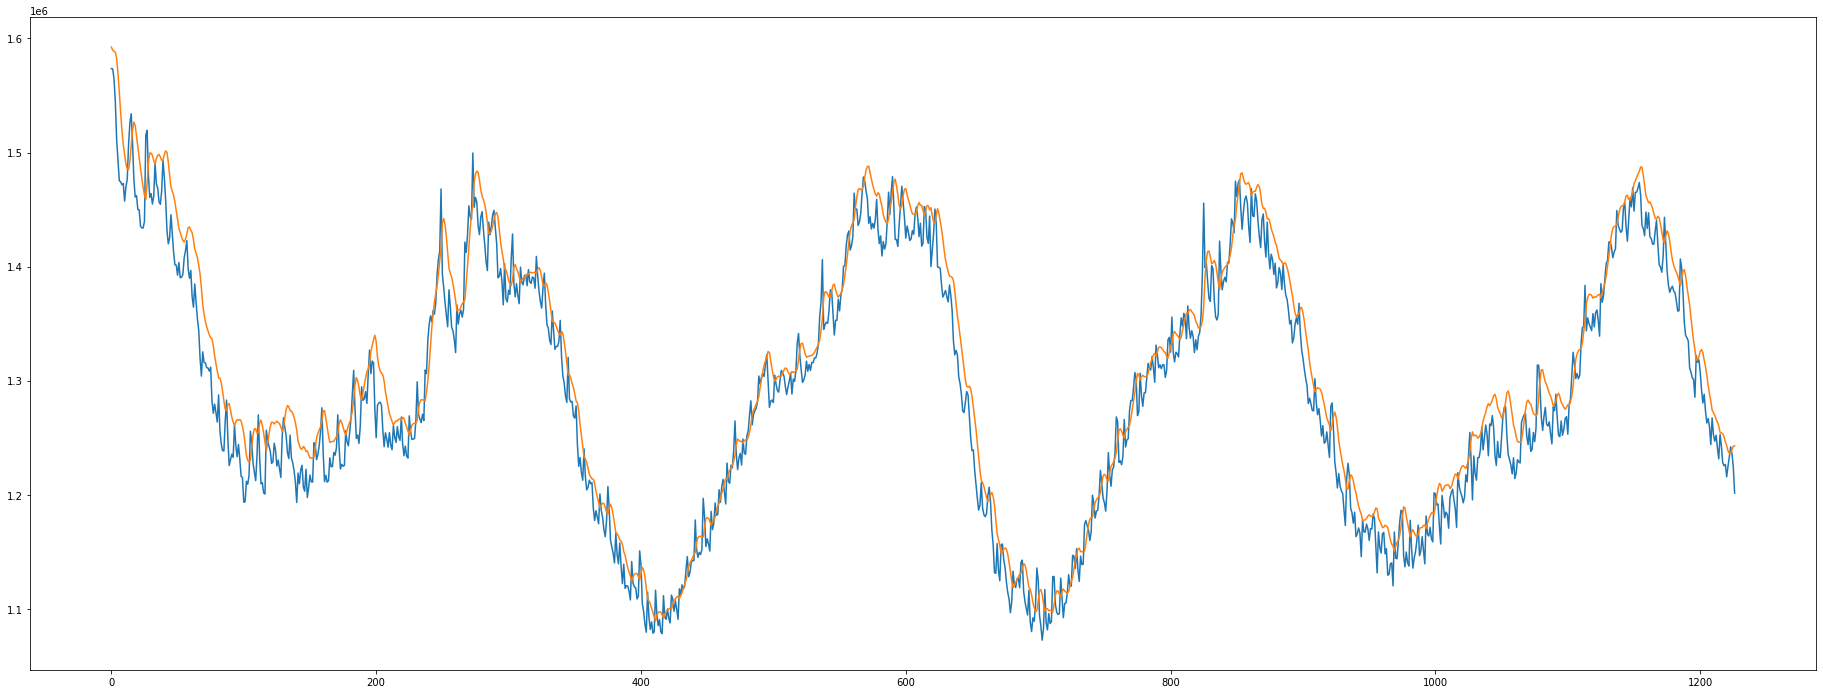

In [40]:
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY= pd.DataFrame(y_test,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(preds,columns=['min_cpu','max_cpu','avg_cpu'])


plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

### Accuracy Scores

In [44]:
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 30275.09 RMSE
Test Score: 149.402938 MAE
Test Score: 1.626808 MAPE
